<a href="https://colab.research.google.com/github/083Tanasub/ITCS225-DownSynDown/blob/main/Os_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install librosa matplotlib pandas scikit-learn tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Clear all variables from the workspace
from IPython import get_ipython
get_ipython().magic('reset -sf')

import os
import shutil

# Clear a specific cache directory (e.g., feature cache)
CACHE_DIR = '/content/feature_cache'

if os.path.exists(CACHE_DIR):
    shutil.rmtree(CACHE_DIR)
    print("Cache directory cleared!")

import tensorflow as tf

# Clear the current TensorFlow/Keras session
tf.keras.backend.clear_session()
print("TensorFlow session cleared.")


Cache directory cleared!
TensorFlow session cleared.


In [ ]:
# CPU Version Only (Enhanced with Base Code Structure)
import time
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, LSTM, Reshape, BatchNormalization, InputLayer
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# === ✅ PARAMETERS TO TEST ===
EPOCHS = 5
MAX_WORKERS = 4
IO_BUFFER_SIZE = 32768

# === Step 1: Setup ===
start_time = time.time()
AUDIO_DIR = "/content/drive/MyDrive/MEMD_audio"
ANNOTATION_FILE = "/content/static_annotations_averaged_songs_1_2000.csv"
CACHE_DIR = "/content/feature_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# === Step 2: Load annotations ===
annotations = pd.read_csv(ANNOTATION_FILE)
annotations.columns = [c.strip() for c in annotations.columns]
annotations = annotations[['song_id', 'valence_mean', 'arousal_mean']]

# === Step 3: Feature extraction with caching ===
def extract_or_load(song_id):
    audio_path = os.path.join(AUDIO_DIR, f"{song_id}.mp3")
    cache_path = os.path.join(CACHE_DIR, f"{song_id}.npy")
    if os.path.exists(cache_path):
        return np.load(cache_path), song_id
    try:
        with open(audio_path, 'rb', buffering=IO_BUFFER_SIZE) as f:
            y, sr = librosa.load(f, sr=22050, duration=30)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_db = librosa.util.fix_length(mel_spec_db, size=128, axis=1)
        np.save(cache_path, mel_spec_db)
        return mel_spec_db, song_id
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None, song_id

# === Step 4: Parallel feature extraction ===
X = []
y = []

def collect_results(result):
    feature, song_id = result
    if feature is not None:
        row = annotations[annotations['song_id'] == song_id].iloc[0]
        X.append(feature)
        y.append([row['valence_mean'], row['arousal_mean']])

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    futures = [executor.submit(extract_or_load, int(row['song_id'])) for _, row in annotations.iterrows()]
    for f in tqdm(futures):
        collect_results(f.result())

X = np.array(X)[..., np.newaxis]
y = np.array(y)

# === Step 5: Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Step 6: Build model ===
model = Sequential([
    InputLayer(input_shape=X_train.shape[1:]),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Reshape((32, 32 * 64)),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# === Step 7: Train ===
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=16, validation_split=0.2)

# === Step 8: Evaluate and Save ===
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.4f}")

model.save("model_cpu.h5")
print("✅ Model saved successfully.")

end_time = time.time()
print(f"Total time taken: {end_time - start_time:.2f} seconds")

# === Step 9: Plot training loss ===
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Over Epochs")
plt.grid(True)
plt.show()


100%|██████████| 1744/1744 [00:01<00:00, 896.13it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_8 (Reshape)             │ (None, 32, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │       540,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 562,274 (2.14 MB)

 Trainable params: 562,082 (2.14 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/5
22/70 ━━━━━━━━━━━━━━━━━━━━ 35s 745ms/step - loss: 6.9747 - mae: 2.0779

KeyboardInterrupt: 


Available devices:
[]


100%|██████████| 1744/1744 [06:52<00:00,  4.23it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 32, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       540,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 562,274 (2.14 MB)

 Trainable params: 562,082 (2.14 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 48s 604ms/step - loss: 4.4820 - mae: 1.6134 - val_loss: 9.6939 - val_mae: 2.8598
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 82s 604ms/step - loss: 1.5489 - mae: 1.0094 - val_loss: 2.7683 - val_mae: 1.3741
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 559ms/step - loss: 1.5360 - mae: 0.9937 - val_loss: 1.2358 - val_mae: 0.8965
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 532ms/step - loss: 1.6940 - mae: 1.0416 - val_loss: 1.3313 - val_mae: 0.9187
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 40s 575ms/step - loss: 1.6241 - mae: 1.0349 - val_loss: 1.1749 - val_mae: 0.8636
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 40s 553ms/step - loss: 1.4747 - mae: 0.9856 - val_loss: 1.1219 - val_mae: 0.8463
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 523ms/step - loss: 1.3374 - mae: 0.9334 - val_loss: 1.1637 - val_mae: 0.8493
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 42s 539ms/step - loss: 1.3979 - mae: 0.9554 - val_loss: 1.5967 - val_mae: 0.9912
Epoch 9/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 562ms/

Test MAE: 1.7624
✅ Model saved successfully.
Total time taken: 866.57 seconds


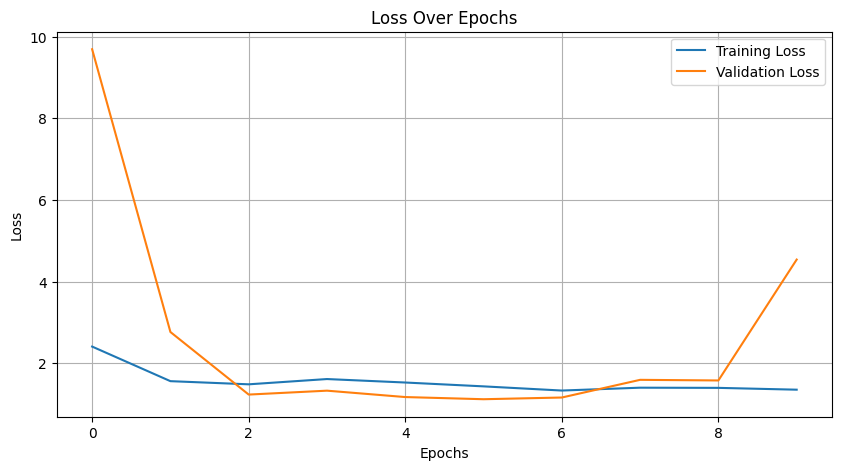

In [ ]:
# GPU Version (Enhanced with Base Code Structure)
import time
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, LSTM, Reshape, BatchNormalization, InputLayer
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# === ✅ PARAMETERS TO TEST ===
EPOCHS = 10
MAX_WORKERS = 2
IO_BUFFER_SIZE = 32768

print("\nAvailable devices:")
print(tf.config.list_physical_devices('GPU'))  # ✅ Check GPU availability

# === Step 1: Setup ===
start_time = time.time()
AUDIO_DIR = "/content/drive/MyDrive/MEMD_audio"
ANNOTATION_FILE = "/content/static_annotations_averaged_songs_1_2000.csv"
CACHE_DIR = "/content/feature_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# === Step 2: Load annotations ===
annotations = pd.read_csv(ANNOTATION_FILE)
annotations.columns = [c.strip() for c in annotations.columns]
annotations = annotations[['song_id', 'valence_mean', 'arousal_mean']]

# === Step 3: Feature extraction with caching ===
def extract_or_load(song_id):
    audio_path = os.path.join(AUDIO_DIR, f"{song_id}.mp3")
    cache_path = os.path.join(CACHE_DIR, f"{song_id}.npy")
    if os.path.exists(cache_path):
        return np.load(cache_path), song_id
    try:
        with open(audio_path, 'rb', buffering=IO_BUFFER_SIZE) as f:
            y, sr = librosa.load(f, sr=22050, duration=30)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_db = librosa.util.fix_length(mel_spec_db, size=128, axis=1)
        np.save(cache_path, mel_spec_db)
        return mel_spec_db, song_id
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None, song_id

# === Step 4: Parallel feature extraction ===
X = []
y = []

def collect_results(result):
    feature, song_id = result
    if feature is not None:
        row = annotations[annotations['song_id'] == song_id].iloc[0]
        X.append(feature)
        y.append([row['valence_mean'], row['arousal_mean']])

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    futures = [executor.submit(extract_or_load, int(row['song_id'])) for _, row in annotations.iterrows()]
    for f in tqdm(futures):
        collect_results(f.result())

X = np.array(X)[..., np.newaxis]
y = np.array(y)

# === Step 5: Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Step 6: Build model ===
model = Sequential([
    InputLayer(input_shape=X_train.shape[1:]),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Reshape((32, 32 * 64)),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# === Step 7: Train ===
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=16, validation_split=0.2)

# === Step 8: Evaluate and Save ===
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.4f}")

model.save("model_gpu.h5")
print("✅ Model saved successfully.")

end_time = time.time()
print(f"Total time taken: {end_time - start_time:.2f} seconds")

# === Step 9: Plot training loss ===
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Over Epochs")
plt.grid(True)
plt.show()


In [ ]:
# TPU Version (Enhanced with Base Code Structure)
import time
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, LSTM, Reshape, BatchNormalization, InputLayer
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# === ✅ PARAMETERS TO TEST ===
EPOCHS = 5
MAX_WORKERS = 2
IO_BUFFER_SIZE = 32768

# === Step 1: Setup TPU Strategy ===
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
except ValueError:
    strategy = None
    print("⚠️ TPU not found. Make sure to switch Colab runtime to TPU.")

start_time = time.time()
AUDIO_DIR = "/content/drive/MyDrive/MEMD_audio"
ANNOTATION_FILE = "/content/static_annotations_averaged_songs_1_2000.csv"
CACHE_DIR = "/content/feature_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

# === Step 2: Load annotations ===
annotations = pd.read_csv(ANNOTATION_FILE)
annotations.columns = [c.strip() for c in annotations.columns]
annotations = annotations[['song_id', 'valence_mean', 'arousal_mean']]

# === Step 3: Feature extraction with caching ===
def extract_or_load(song_id):
    audio_path = os.path.join(AUDIO_DIR, f"{song_id}.mp3")
    cache_path = os.path.join(CACHE_DIR, f"{song_id}.npy")
    if os.path.exists(cache_path):
        return np.load(cache_path), song_id
    try:
        with open(audio_path, 'rb', buffering=IO_BUFFER_SIZE) as f:
            y, sr = librosa.load(f, sr=22050, duration=30)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_db = librosa.util.fix_length(mel_spec_db, size=128, axis=1)
        np.save(cache_path, mel_spec_db)
        return mel_spec_db, song_id
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None, song_id

# === Step 4: Parallel feature extraction ===
X = []
y = []

def collect_results(result):
    feature, song_id = result
    if feature is not None:
        row = annotations[annotations['song_id'] == song_id].iloc[0]
        X.append(feature)
        y.append([row['valence_mean'], row['arousal_mean']])

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    futures = [executor.submit(extract_or_load, int(row['song_id'])) for _, row in annotations.iterrows()]
    for f in tqdm(futures):
        collect_results(f.result())

X = np.array(X)[..., np.newaxis]
y = np.array(y)

# === Step 5: Train/test split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Step 6: Build and Train Model ===
if strategy:
    with strategy.scope():
        model = Sequential([
            InputLayer(input_shape=X_train.shape[1:]),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),

            Conv2D(64, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),

            Reshape((32, 32 * 64)),
            LSTM(64, return_sequences=False),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dense(2, activation='linear')
        ])
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        model.summary()

    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=16, validation_split=0.2)
    loss, mae = model.evaluate(X_test, y_test)
    print(f"Test MAE: {mae:.4f}")
    model.save("model_tpu.h5")
    print("✅ Model saved successfully.")

    # === Step 9: Plot training loss ===
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Over Epochs")
    plt.grid(True)
    plt.show()
else:
    print("⚠️ TPU training skipped.")

end_time = time.time()
print(f"Total time taken: {end_time - start_time:.2f} seconds")


⚠️ TPU not found. Make sure to switch Colab runtime to TPU.


100%|██████████| 1744/1744 [04:54<00:00,  5.91it/s]


⚠️ TPU training skipped.
Total time taken: 295.49 seconds


In [ ]:
model.save("model_gpu.keras")
print("✅ Model saved successfully.")

✅ Model saved successfully.


In [ ]:
## code for predict
import librosa
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("model_cpu.keras")
VALENCE_THRESH = 0.5
AROUSAL_THRESH = 0.5
# Function to extract features from an audio file
def extract_features(file_path, sr=22050, duration=30):
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        mel_spec_db = librosa.util.fix_length(mel_spec_db, size=128, axis=1)  # Ensure size (128, 128)
        return mel_spec_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Function to map valence and arousal to emotion
def map_valence_arousal_to_emotion(valence, arousal):
    if valence >= VALENCE_THRESH and arousal >= AROUSAL_THRESH:
        return "Happy"
    elif valence < VALENCE_THRESH and arousal >= AROUSAL_THRESH:
        return "Angry"
    elif valence < VALENCE_THRESH and arousal < AROUSAL_THRESH:
        return "Sad"
    elif valence >= VALENCE_THRESH and arousal < AROUSAL_THRESH:
        return "Calm"
    else:
        return "Neutral"

# Function to predict emotion from an audio file
def predict_emotion(audio_file):
    features = extract_features(audio_file)
    if features is None:
        return None

    features = features[..., np.newaxis]  # Add channel dimension
    features = np.expand_dims(features, axis=0)  # Add batch dimension

    prediction = model.predict(features)
    valence, arousal = prediction[0]
    emotion = map_valence_arousal_to_emotion(valence, arousal)

    return {
        "valence": round(valence, 3),
        "arousal": round(arousal, 3),
        "emotion": emotion
    }

# Example: Predict emotion for a song
audio_file = "/content/drive/MyDrive/MEMD_audio/823.mp3"  # Replace with path to your test audio
result = predict_emotion(audio_file)

if result:
    print("🎵 Emotion Prediction:")
    print(f"Valence: {result['valence']}")
    print(f"Arousal: {result['arousal']}")
    print(f"Predicted Emotion: {result['emotion']}")


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 17 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
🎵 Emotion Prediction:
Valence: 4.052000045776367
Arousal: 3.884999990463257
Predicted Emotion: Happy
